# Why Feature Selection?

In [2]:
# Import
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import sklearn.linear_model as skl_lm
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import f_classif

from sklearn.feature_selection import chi2


In [3]:
# Import the dataset
df = pd.read_csv('data/Default.csv')

In [4]:
df.set_index('Unnamed: 0', inplace=True)
df['default2'] = df.default.factorize()[0]
df['student2'] = df.student.factorize()[0]

In [5]:
x = df.balance.values.reshape(-1,1) # scikit-learn expects a 2D array not a pd.Series :(
y = df.default2
x

array([[ 729.52649521],
       [ 817.18040656],
       [1073.54916401],
       ...,
       [ 845.41198922],
       [1569.00905338],
       [ 200.92218263]])

In [6]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=40)


In [7]:
X_train_w_intercept = sm.add_constant(pd.DataFrame(X_train))
est = sm.Logit(y_train.to_numpy(), X_train_w_intercept).fit()
est.summary2().tables[1]



Optimization terminated successfully.
         Current function value: 0.081182
         Iterations 10


,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
const,-10.570829,0.399128,-26.484813,1.450155e-154,-11.353105,-9.788552
0,0.005482,0.000245,22.375180,6.868051e-111,0.005002,0.005962


In [8]:
X_test_w_intercept = sm.add_constant(pd.DataFrame(X_test))
y_prob = est.predict(X_test_w_intercept)
y_pred = (y_prob > 0.5).astype(int)

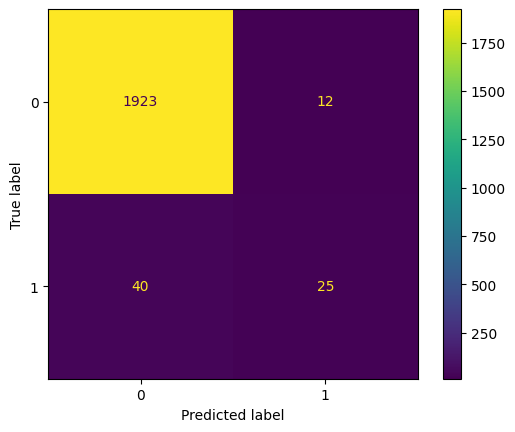

In [9]:
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(cm).plot()
plt.show()

In [10]:
accuracy = metrics.accuracy_score(y_test, y_pred)
accuracy

0.974

In [11]:
# Create 5 new syntetic columns with random values
for i in range(5):
    df[f'random_{i}'] = np.random.rand(df.shape[0])

# Create 5 new columns correlated with balance with some noise
for i in range(5):
    df[f'correlated_{i}'] = df.balance + np.random.normal(0, 100, df.shape[0])



In [12]:
df.columns

Index(['default', 'student', 'balance', 'income', 'default2', 'student2',
       'random_0', 'random_1', 'random_2', 'random_3', 'random_4',
       'correlated_0', 'correlated_1', 'correlated_2', 'correlated_3',
       'correlated_4'],
      dtype='object')

In [13]:
unselected_columns = ['default', 'student', 'default2', 'student2']
selected_columns = [col for col in df.columns if col not in unselected_columns]

In [14]:
df[selected_columns].shape

(10000, 12)

In [15]:
# Select all the columns that are not 'default' or 'student'
X = df[selected_columns]
y = df.default2


In [16]:
X.shape

(10000, 12)

In [17]:
# Divide the dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [18]:
# Fit the model
X_train_w_intercept = sm.add_constant(X_train)
est = sm.Logit(y_train, X_train_w_intercept).fit()
est.summary2().tables[1]

Optimization terminated successfully.
         Current function value: 0.076013
         Iterations 10


,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
const,-11.794225,0.591163,-19.950869,1.473066e-88,-12.952884,-10.635566
balance,0.003541,0.001729,2.047774,4.058210e-02,0.000152,0.006930
income,0.000021,0.000006,3.670177,2.423826e-04,0.000010,0.000032
random_0,0.056657,0.264644,0.214089,8.304774e-01,-0.462036,0.575351
random_1,0.104498,0.269372,0.387931,6.980667e-01,-0.423462,0.632458
random_2,-0.055373,0.270150,-0.204972,8.375943e-01,-0.584858,0.474112
random_3,-0.116177,0.268311,-0.432995,6.650182e-01,-0.642057,0.409703
random_4,-0.088293,0.270133,-0.326851,7.437808e-01,-0.617745,0.441158
correlated_0,0.000870,0.000798,1.089463,2.759498e-01,-0.000695,0.002435
correlated_1,0.000676,0.000784,0.862237,3.885572e-01,-0.000860,0.002212


In [19]:
X_test_w_intercept = sm.add_constant(X_test)
y_prob = est.predict(X_test_w_intercept)
y_pred = (y_prob > 0.5).astype(int)


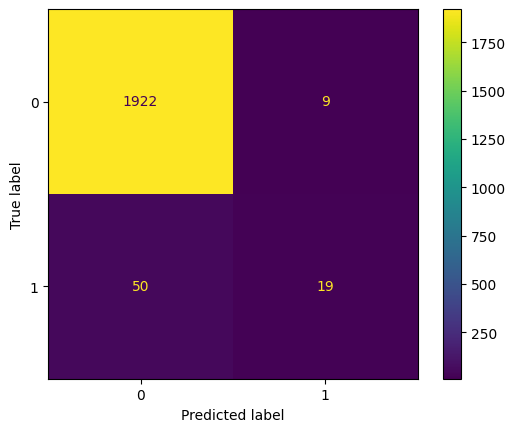

In [20]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(cm).plot()

In [21]:
# Accuracy
new_accuracy = metrics.accuracy_score(y_test, y_pred)
new_accuracy



0.9705

In [22]:
if new_accuracy > accuracy:
    print('The accuracy has improved')
elif new_accuracy == accuracy:
    print('The accuracy is the same')
else:
    print('The accuracy is worse')

The accuracy is worse


# Outlier analysis

In [23]:
phone_df = pd.read_csv('data/phone.csv')
phone_df.head()

,phone_name,brand,os,inches,resolution,battery,battery_type,ram(GB),announcement_date,weight(g),...,video_1080p,video_4K,video_8K,video_30fps,video_60fps,video_120fps,video_240fps,video_480fps,video_960fps,price(USD)
0,Y6II Compact,Huawei,Android 5.1,5.0,720x1280,2200,Li-Po,2,2016-09-01,140.0,...,False,False,False,True,False,False,False,False,False,120.0
1,K20 plus,LG,Android 7.0,5.3,720x1280,2700,Li-Ion,2,2016-12-01,140.0,...,True,False,False,True,False,False,False,False,False,100.0
2,P8 Lite (2017),Huawei,Android 7.0,5.2,1080x1920,3000,Li-Ion,4,2017-01-01,147.0,...,True,False,False,True,False,False,False,False,False,420.0
3,Redmi Note 4,Xiaomi,Android 6.0,5.5,1080x1920,4100,Li-Po,4,2017-01-01,165.0,...,True,False,False,True,False,True,False,False,False,150.0
4,P10,Huawei,Android 7.0,5.1,1080x1920,3200,Li-Ion,4,2017-02-01,145.0,...,True,True,False,True,True,False,False,False,False,420.0


In [24]:
phone_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1512 entries, 0 to 1511
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   phone_name         1512 non-null   object 
 1   brand              1512 non-null   object 
 2   os                 1512 non-null   object 
 3   inches             1512 non-null   float64
 4   resolution         1512 non-null   object 
 5   battery            1512 non-null   int64  
 6   battery_type       1512 non-null   object 
 7   ram(GB)            1512 non-null   int64  
 8   announcement_date  1512 non-null   object 
 9   weight(g)          1512 non-null   float64
 10  storage(GB)        1512 non-null   int64  
 11  video_720p         1512 non-null   bool   
 12  video_1080p        1512 non-null   bool   
 13  video_4K           1512 non-null   bool   
 14  video_8K           1512 non-null   bool   
 15  video_30fps        1512 non-null   bool   
 16  video_60fps        1512 

In [25]:
y = phone_df['price(USD)']
X = phone_df.drop(columns='price(USD)')

In [26]:
# Numerical columns
numeric_columns = X.select_dtypes(include=['float64', 'int64']).columns
print(numeric_columns.to_list())


['inches', 'battery', 'ram(GB)', 'weight(g)', 'storage(GB)']


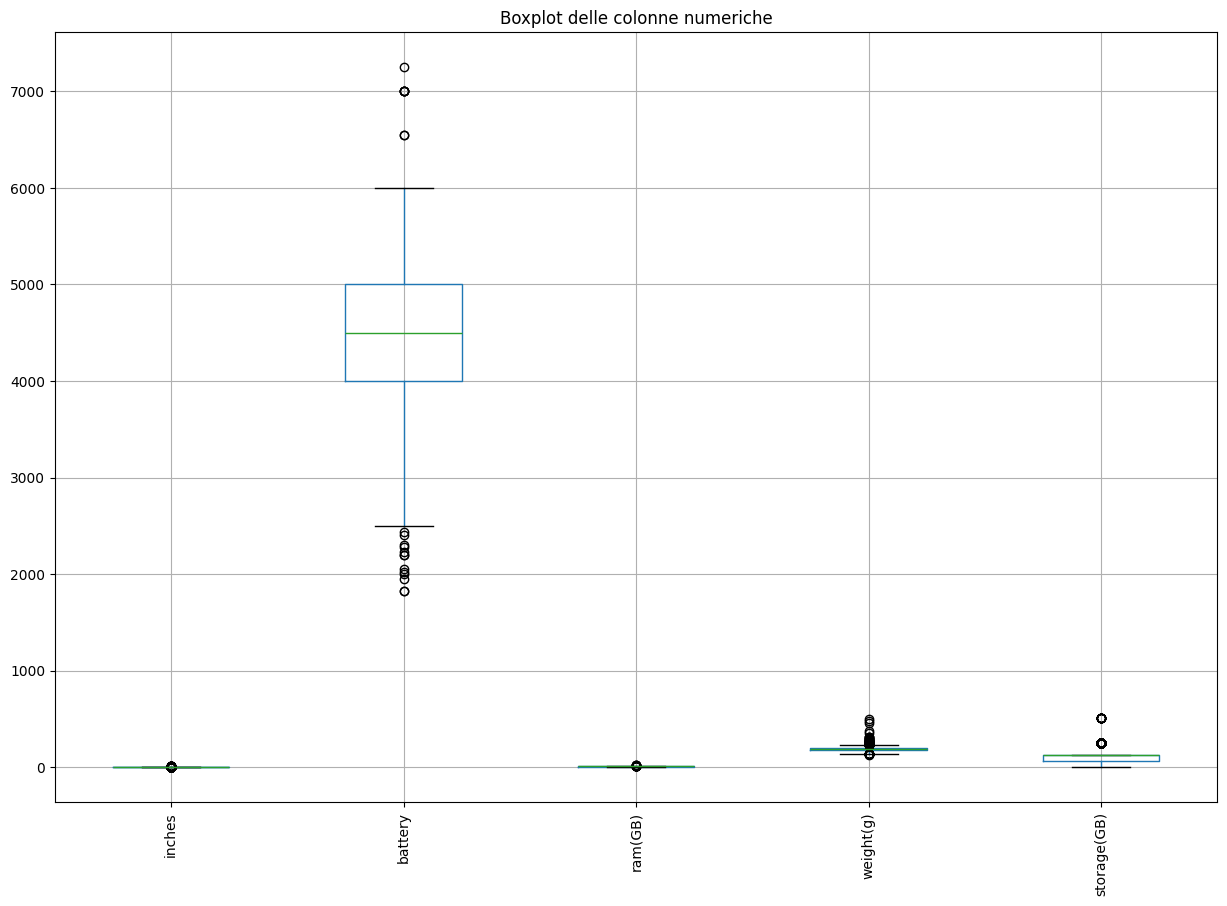

In [27]:
# Boxplot
plt.figure(figsize=(15, 10))
X[numeric_columns].boxplot()
plt.xticks(rotation=90)
plt.title('Boxplot delle colonne numeriche')
plt.show()

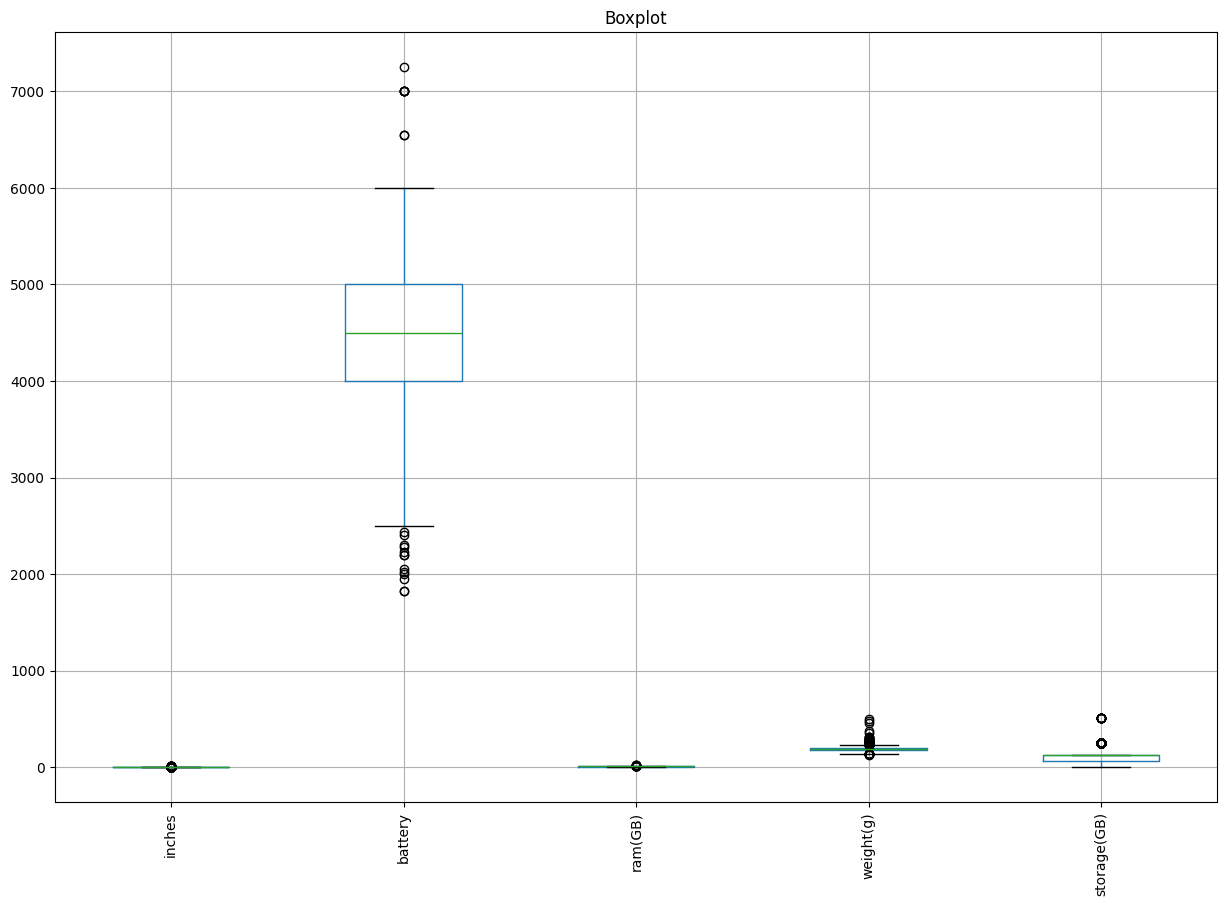

In [28]:
from packages.data_analysis import standard_box_plot

standard_box_plot(X[numeric_columns])

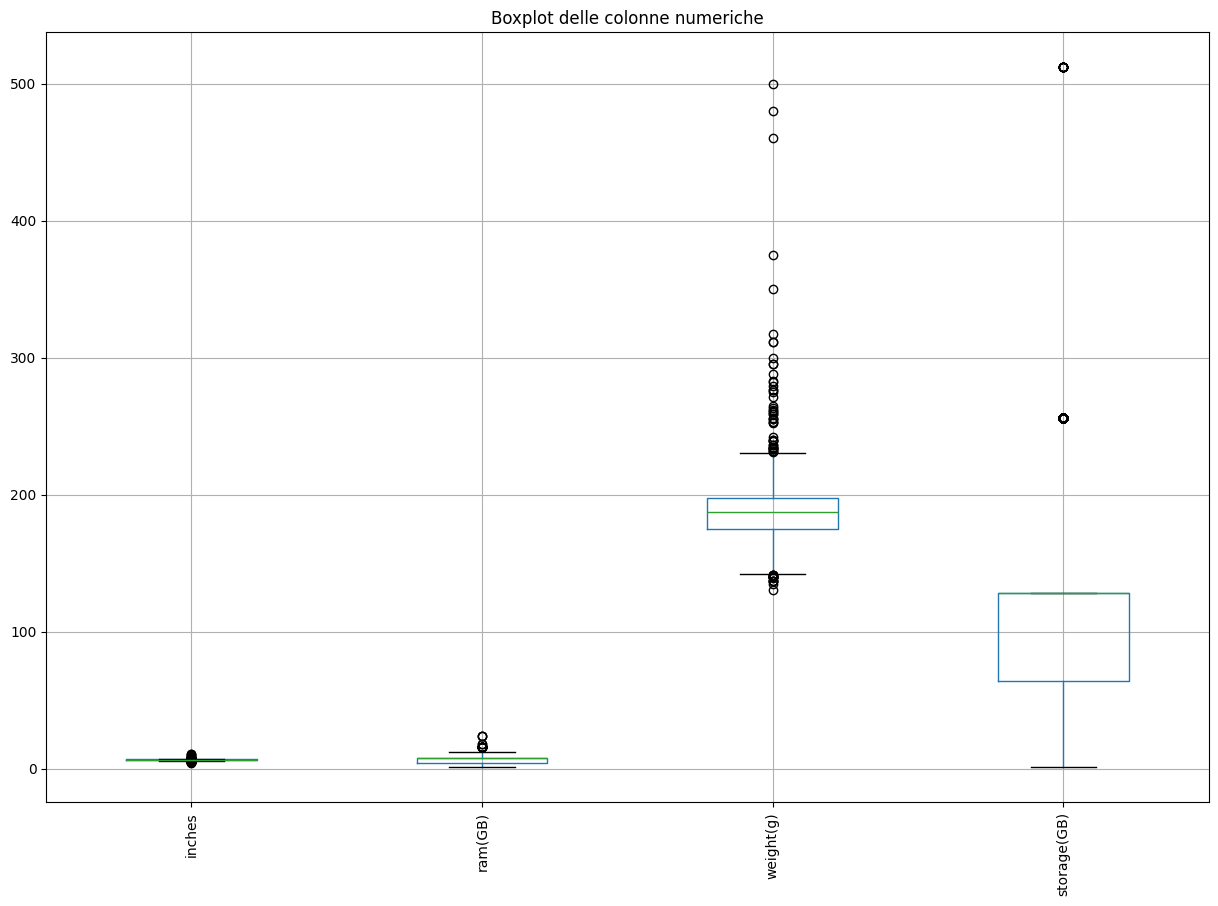

In [29]:
# Boxplot
plt.figure(figsize=(15, 10))
X[numeric_columns].drop(columns='battery').boxplot()
plt.xticks(rotation=90)
plt.title('Boxplot delle colonne numeriche')
plt.show()

In [30]:
X.describe()

,inches,battery,ram(GB),weight(g),storage(GB)
count,1512.000000,1512.000000,1512.000000,1512.000000,1512.000000
mean,6.422460,4389.798942,6.683862,187.636243,109.164683
std,0.477043,784.607022,2.701433,26.200115,74.436484
min,3.800000,1821.000000,1.000000,130.000000,1.000000
25%,6.300000,4000.000000,4.000000,175.000000,64.000000
50%,6.500000,4500.000000,8.000000,187.000000,128.000000
75%,6.670000,5000.000000,8.000000,197.250000,128.000000
max,10.400000,7250.000000,24.000000,500.000000,512.000000


In [31]:
# Interquartile range
def find_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers

outliers = {column: find_outliers(X, column) for column in numeric_columns}
outliers

{'inches':               phone_name    brand           os  inches resolution  battery  \
 0           Y6II Compact   Huawei  Android 5.1    5.00   720x1280     2200   
 1               K20 plus       LG  Android 7.0    5.30   720x1280     2700   
 2         P8 Lite (2017)   Huawei  Android 7.0    5.20  1080x1920     3000   
 3           Redmi Note 4   Xiaomi  Android 6.0    5.50  1080x1920     4100   
 4                    P10   Huawei  Android 7.0    5.10  1080x1920     3200   
 ...                  ...      ...          ...     ...        ...      ...   
 1436          Pixel Fold   Google   Android 13    7.60  1840x2208     4821   
 1489            Magic V2    Honor   Android 13    7.92  2156x2344     5000   
 1492  Legion Y700 (2023)   Lenovo   Android 13    8.80  1600x2560     6550   
 1497      Galaxy Z Fold5  Samsung   Android 13    7.60  1812x2176     4400   
 1504          Mix Fold 3   Xiaomi   Android 13    8.03  1916x2160     4800   
 
      battery_type  ram(GB) announcement

In [32]:
outliers['battery'].head(5)

,phone_name,brand,os,inches,resolution,battery,battery_type,ram(GB),announcement_date,weight(g),...,video_720p,video_1080p,video_4K,video_8K,video_30fps,video_60fps,video_120fps,video_240fps,video_480fps,video_960fps
0,Y6II Compact,Huawei,Android 5.1,5.0,720x1280,2200,Li-Po,2,2016-09-01,140.0,...,True,False,False,False,True,False,False,False,False,False
5,Xperia XA1,Sony,Android 7.0,5.0,720x1280,2300,Li-Ion,3,2017-02-01,143.0,...,False,True,False,False,True,False,False,False,False,False
27,Y3 (2017),Huawei,Android 6.0,5.0,480x854,2200,Li-Ion,1,2017-05-01,175.0,...,True,False,False,False,True,False,False,False,False,False
28,Z4,Samsung,Tizen 3.0,4.5,480x800,2050,Li-Ion,1,2017-05-01,143.0,...,True,False,False,False,True,False,False,False,False,False
45,Galaxy Folder2,Samsung,Android 6.0,3.8,480x800,1950,Li-Ion,3,2017-07-01,165.0,...,False,True,False,False,True,False,False,False,False,False


In [33]:
# Outliers count
outliers_count = {column: len(outliers[column]) for column in numeric_columns}

outliers_stats = {}
for column in numeric_columns:
    outliers_stats[column] = {
        'Number of Outliers': len(outliers[column]),
        'Percentage of Outliers': (len(outliers[column]) / len(df)) * 100,
        'Outlier Values': outliers[column][column].values
    }

outliers_stats_df = pd.DataFrame(outliers_stats).transpose()
outliers_stats_df

,Number of Outliers,Percentage of Outliers,Outlier Values
inches,164,1.64,"[5.0, 5.3, 5.2, 5.5, 5.1, 5.0, 5.2, 5.5, 5.5, ..."
battery,21,0.21,"[2200, 2300, 2200, 2050, 1950, 1821, 2000, 700..."
ram(GB),35,0.35,"[16, 16, 16, 16, 16, 18, 16, 18, 16, 16, 16, 1..."
weight(g),65,0.65,"[140.0, 140.0, 141.0, 140.0, 137.0, 130.0, 500..."
storage(GB),167,1.67,"[256, 256, 512, 256, 256, 512, 512, 256, 512, ..."


# Feature Selection
Feature selection is primarily focused on removing non-informative or redundant predictors from the model.



### Regression Feature Selection: (Numerical Input, Numerical Output)
Pearson's Correlation Coefficient via the f_regression()

In [34]:
# pearson's correlation feature selection for numeric input and numeric output
from sklearn.datasets import make_regression
from sklearn.feature_selection import SelectKBest, RFE
from sklearn.feature_selection import f_regression
# Informative features numeber
n_informative = 5
# generate dataset
X, y = make_regression(n_samples=2000, n_features=10, n_informative=n_informative, random_state=42)
# Informative features
informative_indices = list(range(n_informative))
# define feature selection
fs = SelectKBest(score_func=f_regression, k=n_informative)
# apply feature selection
X_selected = fs.fit_transform(X, y)
print(X_selected.shape)

(2000, 5)


In [35]:
selected_indices = fs.get_support(indices=True)
selected_features = [str(i) for i in selected_indices]

print("Caratteristiche selezionate:", selected_features)

# Verify intersection between selected and informative features
selected_informative = set(informative_indices).intersection(set(selected_indices))

print("Caratteristiche informative originali selezionate:", selected_informative)

Caratteristiche selezionate: ['0', '1', '3', '4', '6']
Caratteristiche informative originali selezionate: {np.int64(0), np.int64(1), np.int64(3), np.int64(4)}


### Classification Feature Selection: (Numerical Input, Categorical Output)
ANOVA F measure via the f_classif() function

In [36]:
# ANOVA feature selection for numeric input and categorical output
from sklearn.datasets import make_classification
from sklearn.feature_selection import SelectKBest
# Informative features numeber
n_informative = 5
# generate dataset
X, y = make_classification(n_samples=2000, n_features=10, n_informative=n_informative, random_state=42)
# Informative features
informative_indices = list(range(n_informative))
# define feature selection
fs = SelectKBest(score_func=f_classif, k=n_informative)
# apply feature selection
X_selected = fs.fit_transform(X, y)
print(X_selected.shape)

(2000, 5)


In [37]:
selected_indices = fs.get_support(indices=True)
selected_features = [str(i) for i in selected_indices]

print("Caratteristiche selezionate:", selected_features)

# Verify intersection between selected and informative features
selected_informative = set(informative_indices).intersection(set(selected_indices))

print("Caratteristiche informative originali selezionate:", selected_informative)

Caratteristiche selezionate: ['0', '1', '3', '4', '5']
Caratteristiche informative originali selezionate: {np.int64(0), np.int64(1), np.int64(3), np.int64(4)}


### Classification Feature Selection: (Categorical Input, Categorical Output)

In [47]:
# Informative features numeber
n_informative = 5

# ANOVA feature selection for numeric input and categorical output
X, y = make_classification(n_samples=2000, n_features=10, n_informative=n_informative, random_state=42)

# Create cols names
X_columns = [f'feature_{i}' for i in range(X.shape[1])] 
X = pd.DataFrame(X, columns=X_columns)
X.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9
0,1.719421,-0.995037,1.347159,-0.105095,2.238050,0.120165,0.630093,0.341180,0.365803,-1.431276
1,1.628344,-0.526241,0.116202,1.399840,1.955209,0.610469,-0.102266,1.759813,0.484695,-1.058643
2,0.855182,1.525454,1.932957,-2.284388,-1.581202,1.583316,0.696688,-0.174947,-0.090593,0.141984
3,-0.941105,0.497089,0.092564,-1.726259,0.285517,1.766985,0.434362,-1.748067,-1.935114,0.172213
4,2.071204,-2.098212,-0.411422,1.224860,1.119426,-2.787236,0.373257,-0.193602,1.895603,-0.823585


In [48]:
# Create bins for each column
X_binned = pd.DataFrame(columns=X_columns)
for column in X_columns:
    X_binned[str(column)] = pd.cut(X[column], bins=5, labels=False)

# Convert every column to categorical
for column in X_binned.columns:
    X_binned[column] = X_binned[column].astype('category')

X_binned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   feature_0  2000 non-null   category
 1   feature_1  2000 non-null   category
 2   feature_2  2000 non-null   category
 3   feature_3  2000 non-null   category
 4   feature_4  2000 non-null   category
 5   feature_5  2000 non-null   category
 6   feature_6  2000 non-null   category
 7   feature_7  2000 non-null   category
 8   feature_8  2000 non-null   category
 9   feature_9  2000 non-null   category
dtypes: category(10)
memory usage: 21.7 KB


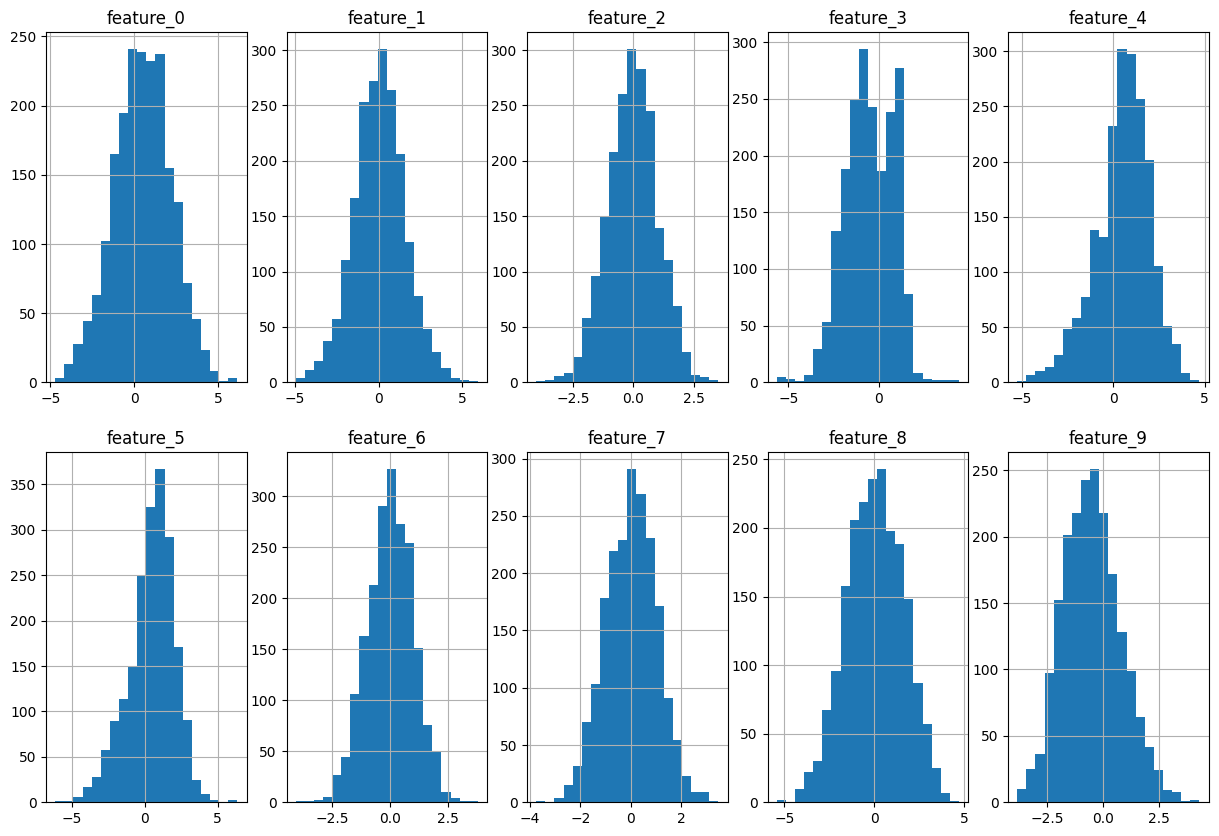

In [44]:
# Create histograms for x 
plt.figure(figsize=(15, 10))
for i, column in enumerate(X_columns):
    plt.subplot(2, 5, i + 1)
    X[column].hist(bins=20)
    plt.title(column)
plt.show()


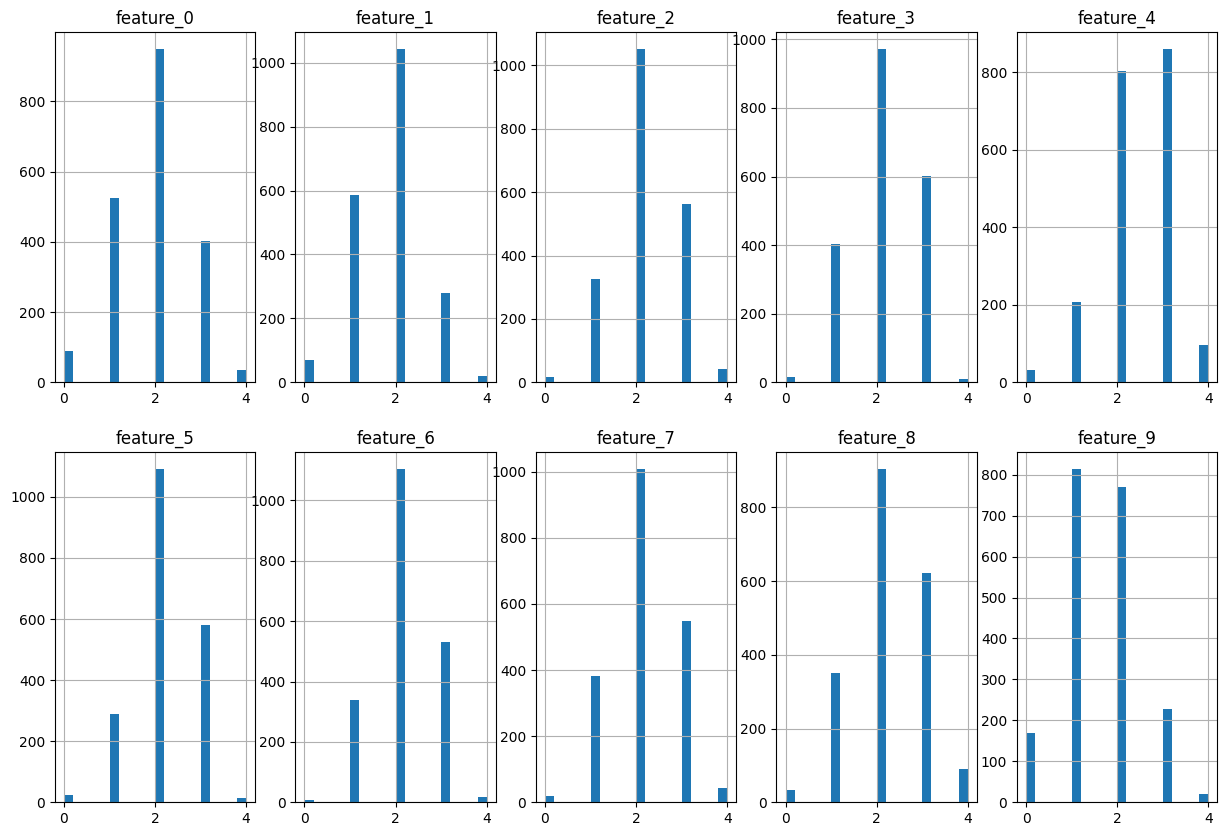

In [45]:
# Create histograms for x binned
plt.figure(figsize=(15, 10))
for i, column in enumerate(X_columns):
    plt.subplot(2, 5, i + 1)
    X_binned[column].hist(bins=20)
    plt.title(column)
plt.show()

In [49]:
X_binned['feature_0'].unique()

[2, 1, 3, 0, 4]
Categories (5, int64): [0, 1, 2, 3, 4]

In [43]:
X_binned.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9
0,2,1,3,2,3,2,2,2,2,1
1,2,2,2,3,3,2,2,3,2,1
2,2,2,3,1,1,3,3,2,2,2
3,1,2,2,1,2,3,2,1,1,2
4,3,1,2,3,3,1,2,2,3,1


In [39]:
from packages.data_analysis import standard_OHE

X_encoded = standard_OHE(X_binned)
X_encoded.head()

,feature_0_0,feature_0_1,feature_0_2,feature_0_3,feature_0_4,feature_1_0,feature_1_1,feature_1_2,feature_1_3,feature_1_4,...,feature_8_0,feature_8_1,feature_8_2,feature_8_3,feature_8_4,feature_9_0,feature_9_1,feature_9_2,feature_9_3,feature_9_4
0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


In [40]:
# Informative features
informative_indices = list(range(n_informative))

# Convert to numpy array
X_encoded = X_encoded.values

# Define feature selection
fs = SelectKBest(score_func=chi2, k=n_informative)

# Apply feature selection
X_selected = fs.fit_transform(X_encoded, y)
print(X_selected.shape)

(2000, 5)


In [41]:
selected_indices = fs.get_support(indices=True)
selected_features = [str(i) for i in selected_indices]

print("Selected Features:", selected_features)

for i in selected_indices:
    if i < n_informative*5:
        print(f"Original informative feature: {i//5} - Binned feature: {i}")

Selected Features: ['8', '17', '18', '21', '26']
Original informative feature: 1 - Binned feature: 8
Original informative feature: 3 - Binned feature: 17
Original informative feature: 3 - Binned feature: 18
Original informative feature: 4 - Binned feature: 21
